# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

__Признаки__
 - `DateCrawled` — дата скачивания анкеты из базы
 - `VehicleType` — тип автомобильного кузова
 - `RegistrationYear` — год регистрации автомобиля
 - `Gearbox` — тип коробки передач
 - `Power` — мощность (л. с.)
 - `Model` — модель автомобиля
 - `Kilometer` — пробег (км)
 - `RegistrationMonth` — месяц регистрации автомобиля
 - `FuelType` — тип топлива
 - `Brand` — марка автомобиля
 - `Repaired` — была машина в ремонте или нет
 - `DateCreated` — дата создания анкеты
 - `NumberOfPictures` — количество фотографий автомобиля
 - `PostalCode` — почтовый индекс владельца анкеты (пользователя)
 - `LastSeen` — дата последней активности пользователя

__Целевой признак__
 - `Price` — цена (евро)

Для корректного завершения выполнения ячеек с кодом в проекте необходимо установить библиотеик `optuna` и `lightgbm`

In [1]:
!pip install --quiet optuna

In [2]:
import optuna
optuna.__version__

'3.1.0'

In [3]:
!pip3 install lightgbm

In [4]:
import lightgbm as lgb
lgb.__version__

'3.3.5'

In [5]:
from lightgbm import LGBMRegressor

Так же установми новую версию библиотеки `sklearn`

In [6]:
!pip install -q scikit-learn==1.2.2

In [7]:
import sklearn
sklearn.__version__

'1.2.2'

In [8]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

# comment for development to enable warnings and optuna info logs
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

%matplotlib inline

RANDOM_STATE = 732568

## Подготовка данных

In [9]:
def load_dataset(dataset_name):
    return pd.read_csv('datasets/' + dataset_name)

In [10]:
def general_info(df: pd.core.frame.DataFrame):
    rows_number = 5
    subdataframe_length = 10000
    
    separator_symbols_count = 100
    
    print(f'Первые {rows_number} строк датасета')
    display(df.head(rows_number))
    print('='*separator_symbols_count, '\n')
    print('Общая информация о признаках')
    print()
    df.info()
    print('='*separator_symbols_count, '\n')
    print('Количество признаков, которые имеют пропущенные значения:', df.isna().any().sum())
    print()
    print('Доля признаков, которые имеют пропущенные значения',
          round(df.isna().any().sum() / df.shape[1], 2))
    print()
    print('='*separator_symbols_count, '\n')
    print('Количество явных дубликатов:', df.duplicated().sum())
    print()
    print('='*separator_symbols_count, '\n')
    print('Описательные статистики признаков')
    display(df.describe().round(2))
    print('='*separator_symbols_count, '\n')
    print('Коэффициенты корреляции признаков')
    display(df.corr().style.background_gradient().set_precision(2))
    print('='*separator_symbols_count, '\n')
    print('Гистограммы и парные диаграммы рассеивания')
    sns.pairplot(
        df.sample(n=subdataframe_length),
        kind='scatter'
    );

Первые 5 строк датасета


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Общая информация о признаках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  o

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.00,354369.00,354369.00,354369.00,354369.00,354369.0,354369.00
mean,4416.66,2004.23,110.09,128211.17,5.71,0.0,50508.69
std,4514.16,90.23,189.85,37905.34,3.73,0.0,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.0,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.0,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.0,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.0,71083.00
max,20000.00,9999.00,20000.00,150000.00,12.00,0.0,99998.00



Коэффициенты корреляции признаков


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.00,0.03,0.16,-0.33,0.11,nan,0.08
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.01,nan,-0.00
Power,0.16,-0.00,1.00,0.02,0.04,nan,0.02
Kilometer,-0.33,-0.05,0.02,1.00,0.01,nan,-0.01
RegistrationMonth,0.11,-0.01,0.04,0.01,1.00,nan,0.01
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.08,-0.00,0.02,-0.01,0.01,nan,1.00



Гистограммы и парные диаграммы рассеивания


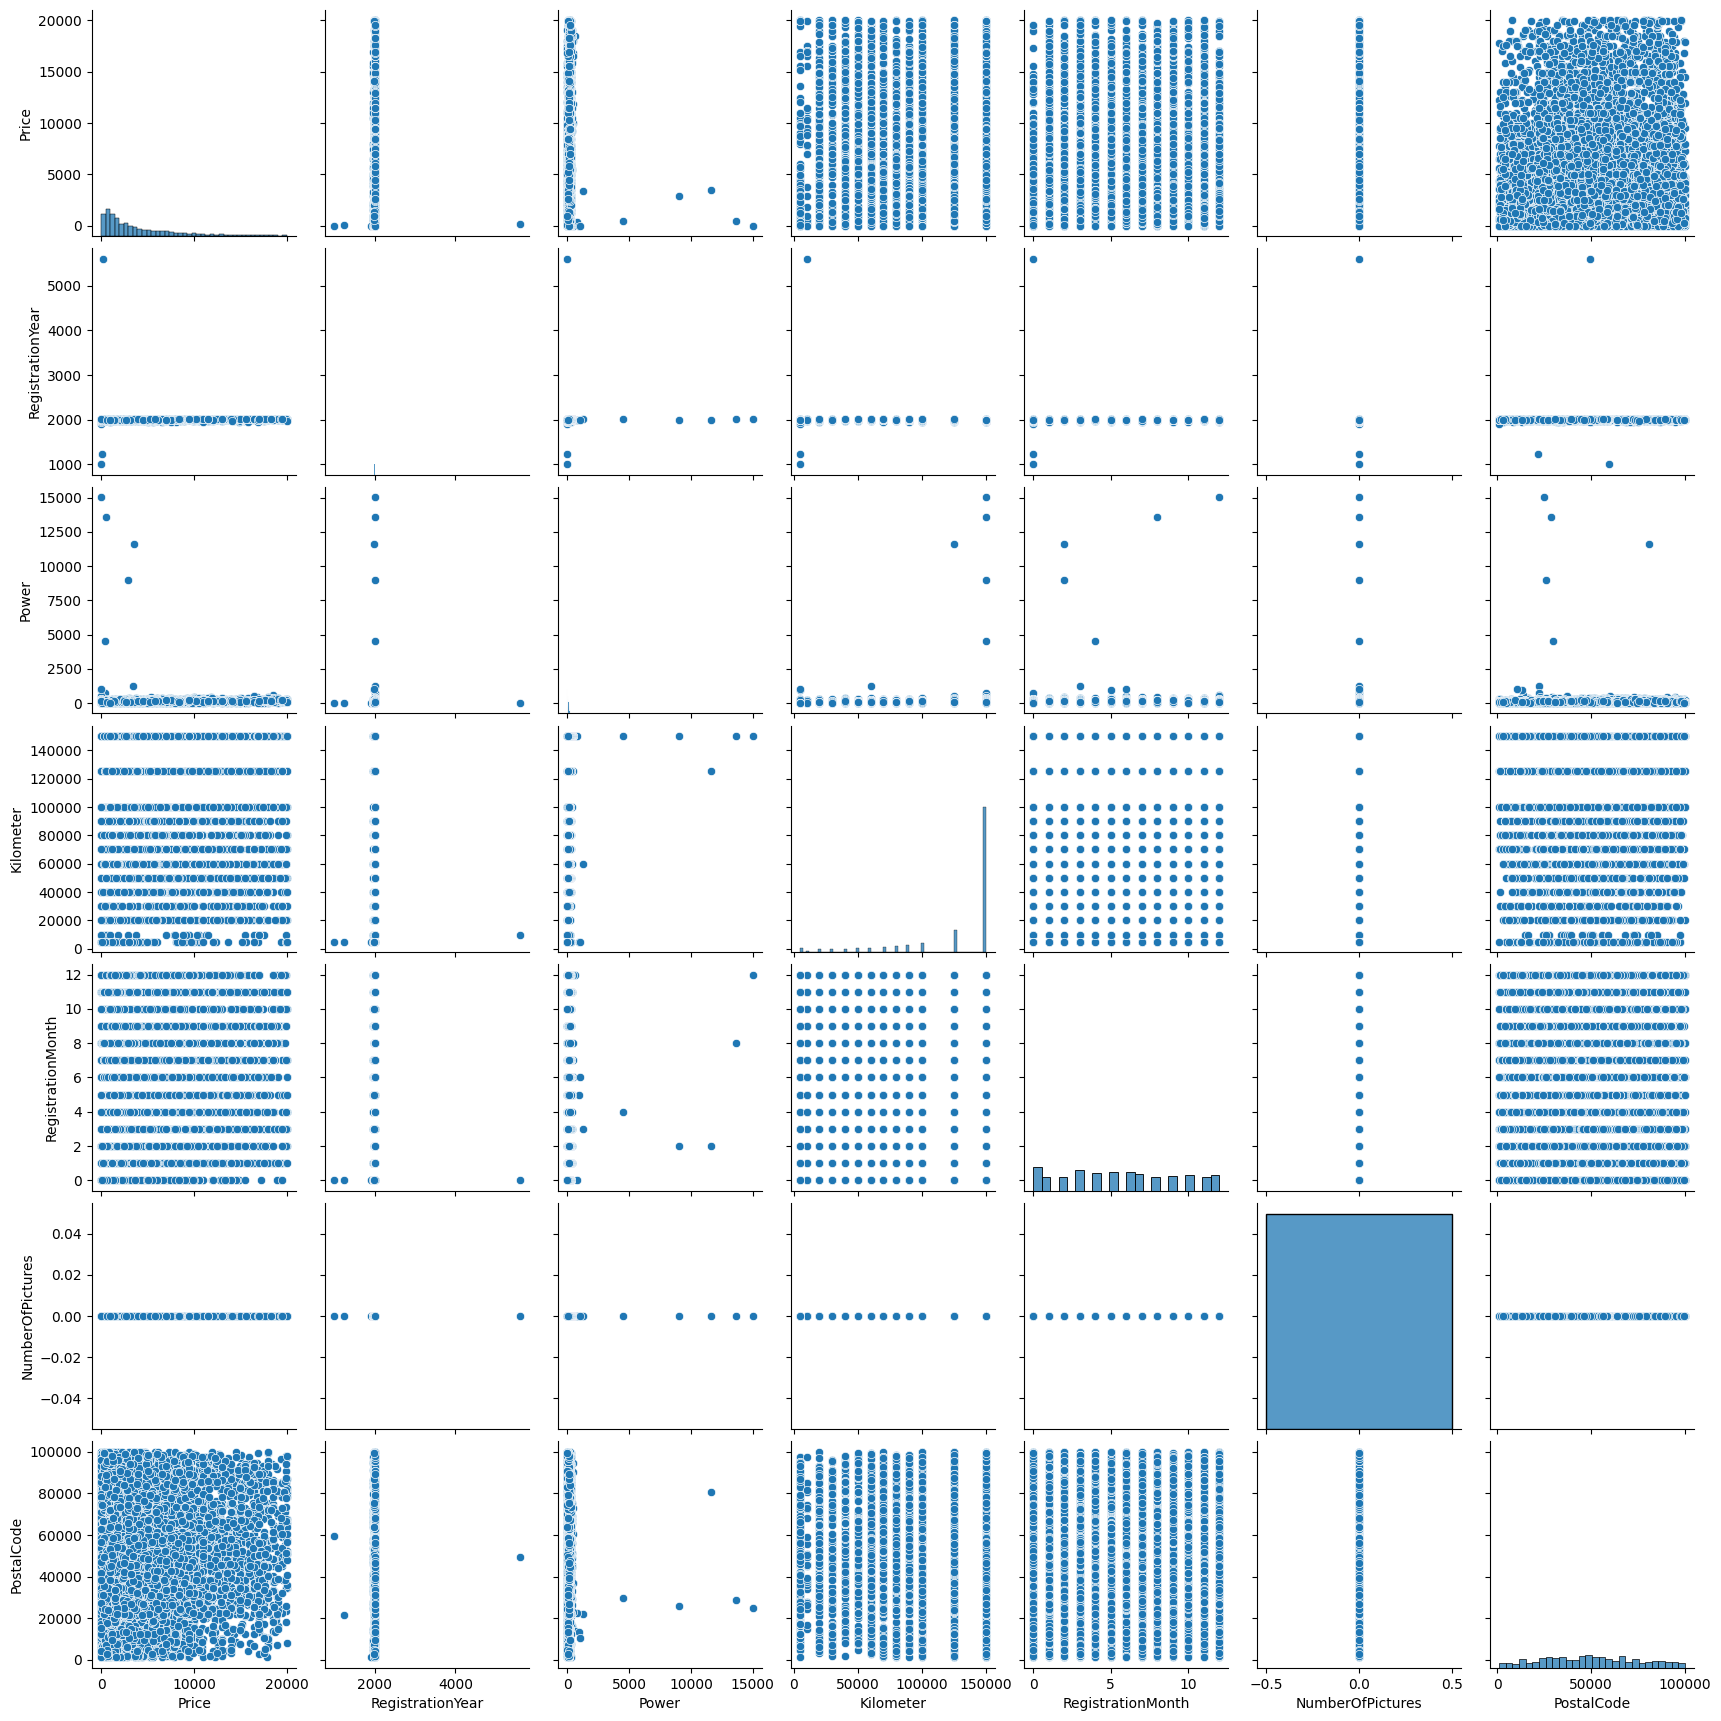

In [11]:
data = load_dataset('autos.csv')
general_info(data)

### Выводы по общей информации о данных

 - датасет состоит из 354369 объектов и 16 признаков, в том числе 1 целевой признак `Price`;
 - 5 признаков содержат пропущенные значения;
 - по таблице корелляции можно отметить, что:
    - наибольша коррелция с целевым признаком у признака `Kilometer`, и составляет `-0.33`;
    - корреляция между количественными признакакми (исключая целевой) практически нулевая;
 - по диаграмма рассеивания можно отметить, что признак `NumberOfPictures` содержит только нулевые значения.

### Переименование признаков

Переименуем признаки к формату `snake_case` по общепринятым для Python стандартам

In [12]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [13]:
def to_snake_case(str):
    column_name_words =  re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)
    return '_'.join([word.lower() for word in column_name_words])

In [14]:
data.columns = [to_snake_case(column) for column in data.columns]

In [15]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Обработка пропусков

In [16]:
gaps_info = (
    pd.concat(
        [
            data.isna().sum().loc[lambda x : (x > 0)],
            (data.isna().sum() / data.shape[0] * 100).loc[lambda x : (x > 0)].round(2)
        ],
        axis=1
    )
)
gaps_info.columns = ['Количество пропусков, щт.', 'в процентах']
gaps_info

,"Количество пропусков, щт.",в процентах
vehicle_type,37490,10.58
gearbox,19833,5.60
model,19705,5.56
fuel_type,32895,9.28
repaired,71154,20.08


In [17]:
print('Всего строк в датасете', data.shape[0])

Всего строк в датасете 354369


Посмотрим отдельно как каждый признак с пропусками

In [18]:
data.vehicle_type.isna().sum()

37490

In [19]:
(data.vehicle_type.value_counts(1, dropna=False) * 100).round(2)

sedan          25.81
small          22.53
wagon          18.39
NaN            10.58
bus             8.12
convertible     5.70
coupe           4.56
suv             3.39
other           0.93
Name: vehicle_type, dtype: float64

In [20]:
data.gearbox.isna().sum()

19833

In [21]:
(data.gearbox.value_counts(1, dropna=False) * 100).round(2)

manual    75.70
auto      18.71
NaN        5.60
Name: gearbox, dtype: float64

In [22]:
data.model.isna().sum()

19705

In [23]:
data.model.value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [24]:
data.fuel_type.isna().sum()

32895

In [25]:
(data.fuel_type.value_counts(1, dropna=False) * 100).round(2)

petrol      61.05
gasoline    27.86
NaN          9.28
lpg          1.50
cng          0.16
hybrid       0.07
other        0.06
electric     0.03
Name: fuel_type, dtype: float64

In [26]:
data.repaired.isna().sum()

71154

In [27]:
(data.repaired.value_counts(1, dropna=False) * 100).round(2)

no     69.75
NaN    20.08
yes    10.17
Name: repaired, dtype: float64

Все признаки категориальные.\
Наиболее правильным решением будет заменить пропущенные значения на значение `unknown`.

In [28]:
data = data.fillna('unknown')

In [29]:
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Обработка аномальных значений

Проверим категориальные и количественные признаки на аномальные значения

In [30]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [31]:
date_columns = ['date_crawled', 'date_created', 'last_seen']

In [32]:
numeric_columns = list(data.select_dtypes([np.number]).columns)
numeric_columns

['price',
 'registration_year',
 'power',
 'kilometer',
 'registration_month',
 'number_of_pictures',
 'postal_code']

In [33]:
categorical_columns = list(data.columns.difference(date_columns + list(numeric_columns)))
categorical_columns

['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']

#### Категориальные признаки

In [34]:
categorical_columns

['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']

In [35]:
data.brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [36]:
data.fuel_type.unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [37]:
data.gearbox.unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [38]:
data.model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [39]:
data.repaired.unique()

array(['unknown', 'yes', 'no'], dtype=object)

In [40]:
data.vehicle_type.unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

По визуальной оценке значений категориальных признаков, можно сделать вывод, что они не имеют аномальных значений.

#### Количественные признаки

In [41]:
numeric_columns

['price',
 'registration_year',
 'power',
 'kilometer',
 'registration_month',
 'number_of_pictures',
 'postal_code']

##### `price`

In [42]:
data.price.describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [43]:
data.price.value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [44]:
data.price.value_counts(1)

0        0.030398
500      0.016000
1500     0.015221
1000     0.013119
1200     0.012964
           ...   
1368     0.000003
233      0.000003
11080    0.000003
16340    0.000003
10985    0.000003
Name: price, Length: 3731, dtype: float64

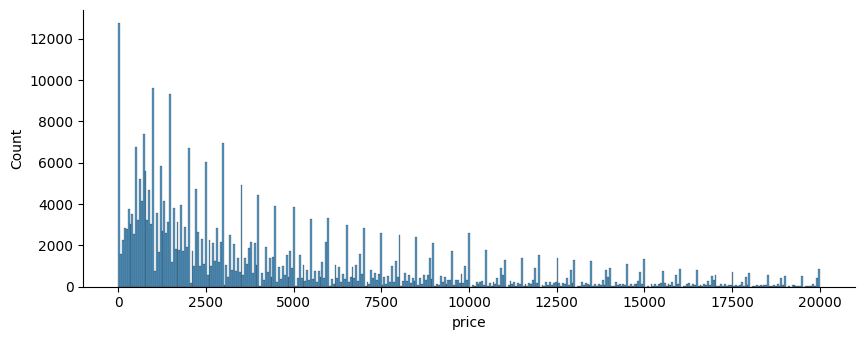

In [45]:
sns.displot(
    data.price,
    bins=data.price.nunique()//10,
    height=3.5,
    aspect=2.5
);

Видно, что целевой признак `price` имеет нулевое значение, которое наиболее вероятно является аномальным значения, поскольку заказчиком проекта является сервис по продаже автомобилей, что подразумевает цену отличную от нуля.

ОБъектов со значением `0` в целевом признаке 10772, это 3% от общего количества объектов в датасете.\
Удалим такие объекты.

In [46]:
data = data.drop(index=data[data.price == 0].index)

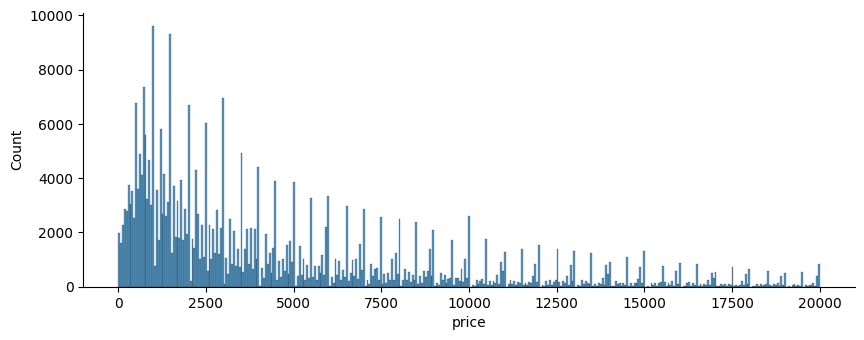

In [47]:
sns.displot(
    data.price,
    bins=data.price.nunique()//10,
    height=3.5,
    aspect=2.5
);

##### `registration_year`

In [48]:
data.registration_year.sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100,
       7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999], dtype=int64)

В данном списке аномальными яявляются значения ниже `1910` и выше `2019`

In [49]:
abnormal_registration_year = data.query('registration_year < 1910 or registration_year > 2016')

In [50]:
abnormal_registration_year.shape

(13832, 16)

Таких объектов в датасете `13832`. Удалим их.

In [51]:
data = data.drop(index=abnormal_registration_year.index)

In [52]:
data.registration_year.sort_values().unique()

array([1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016], dtype=int64)

##### `power`

In [53]:
data.power.nunique()

685

In [54]:
data.power.sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

На первый взгляд весь список возможных мощностей автомобилей выглядит списком аномальных значения.\
Построим гистограмму этого признака.

In [55]:
data.power.value_counts()

0        32866
75       22144
60       14774
150      13750
101      12415
         ...  
1506         1
5809         1
15020        1
5867         1
1241         1
Name: power, Length: 685, dtype: int64

In [56]:
data.power.value_counts(1)

0        0.099665
75       0.067151
60       0.044802
150      0.041696
101      0.037648
           ...   
1506     0.000003
5809     0.000003
15020    0.000003
5867     0.000003
1241     0.000003
Name: power, Length: 685, dtype: float64

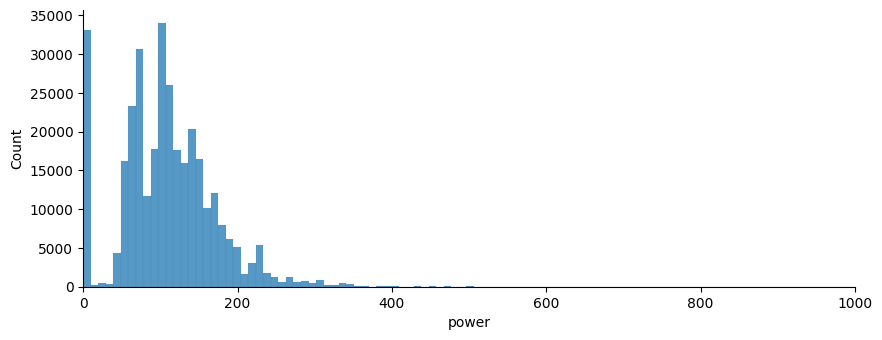

In [57]:
sns.displot(
    data.power,
    bins=data.power.nunique() * 3,
    height=3.5,
    aspect=2.5
)
plt.xlim(0, 1000);

In [58]:
data[data.power > 400].shape

(659, 16)

In [59]:
data[data.power == 0].shape

(32866, 16)

Видно, что
 - для 36259 (10,5 %) автомобилей указана нулевая мощность, что является аномалией. Возможно это пропущенные значения, которые заменены на `0`;
 - основная масса значение мощности сосредоточена от 0 до 400;
 - при этом автомобиле с мощностью более `400` всего `659` в датасет.

Предположим, что значения выше 400 это аномальные значения. Косвенным подтвержением этому может быть, что в датасете представлены автомобили с максимальной ценой 20000. Наиболее вероятно, что автомобили с мощностью выше 400 стоят дороже.

Удалим записи с нулевыми значением, и со значениями выше `400`

In [60]:
abnormal_power = data.query('power == 0 or power > 400')

In [61]:
round((abnormal_power.shape[0] / data.shape[0] * 100), 2)

10.17

In [62]:
abnormal_power.shape

(33525, 16)

In [63]:
data = data.drop(index=abnormal_power.index)

In [64]:
data.shape[0]

296240

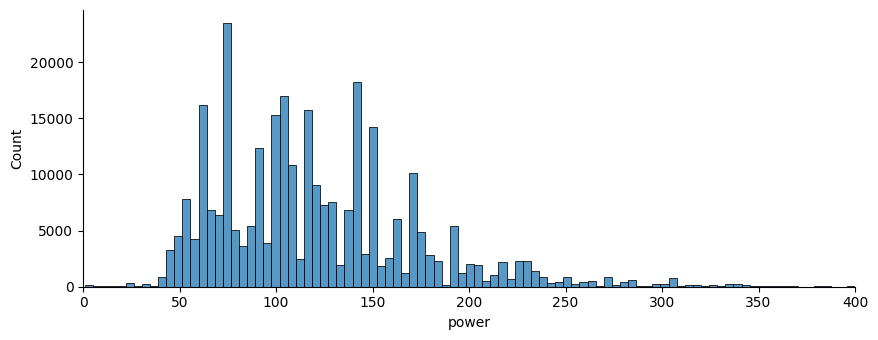

In [65]:
sns.displot(
    data.power,
    bins=data.power.nunique() // 4,
    height=3.5,
    aspect=2.5
)
plt.xlim(0, 400);

##### `kilometer`

In [66]:
data.kilometer.sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

In [67]:
data.kilometer.value_counts()

150000    196401
125000     31788
100000     12833
90000      10311
80000       9035
70000       7814
60000       6845
50000       5661
40000       4518
30000       3922
20000       3288
5000        2893
10000        931
Name: kilometer, dtype: int64

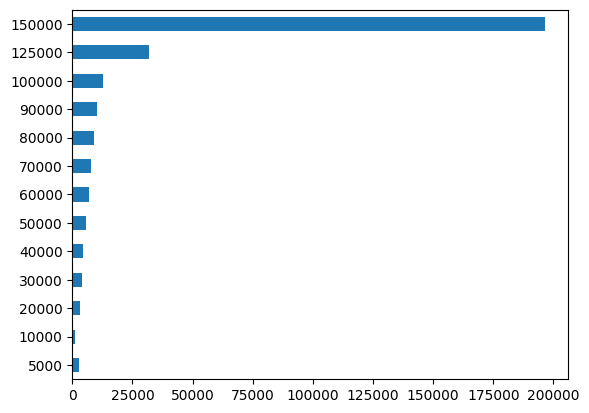

In [68]:
data.kilometer.value_counts().sort_index(ascending=True).plot(kind='barh');

В этом признаке нет аномальных значений

##### `registration_month`

In [69]:
data.registration_month.sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [70]:
data.registration_month.value_counts()

3     30436
6     27586
4     25773
5     25648
7     23845
10    22966
12    21213
11    21046
9     20960
1     20204
8     19739
2     18857
0     17967
Name: registration_month, dtype: int64

In [71]:
data.registration_month.value_counts(1)

3     0.102741
6     0.093120
4     0.087000
5     0.086578
7     0.080492
10    0.077525
12    0.071607
11    0.071044
9     0.070753
1     0.068201
8     0.066632
2     0.063654
0     0.060650
Name: registration_month, dtype: float64

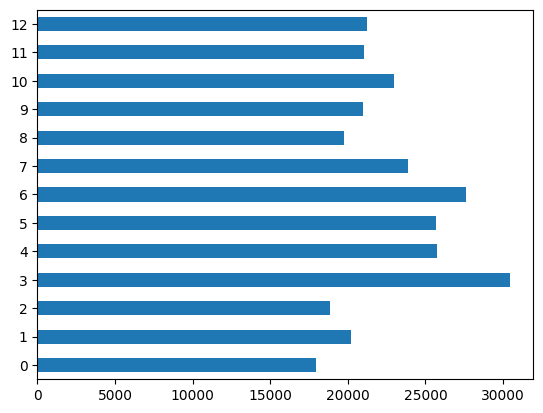

In [72]:
data.registration_month.value_counts().sort_index(ascending=True).plot(kind='barh');

Видно, что одно из значений аномальное: либо `0` либо `12`. Какое из них некорректоне выснить не получится. Можно так же преположить, что датасет был составлены из данных разных источников: в одном нумерация месяцев была от `0` до `11`, в другом с `1` до `12`.\
Пока что оставим эти данные как есть.

##### `number_of_pictures`

In [73]:
data.number_of_pictures.value_counts()

0    296240
Name: number_of_pictures, dtype: int64

Одни нули. Неинформативный признак. Удаляем.

In [74]:
data = data.drop(columns='number_of_pictures')

##### `postal_code`

In [75]:
data.postal_code.nunique()

8116

In [76]:
data.postal_code.value_counts().head(10)

10115    798
65428    505
66333    275
60311    261
52525    248
78224    247
32257    245
44145    239
38518    239
40764    238
Name: postal_code, dtype: int64

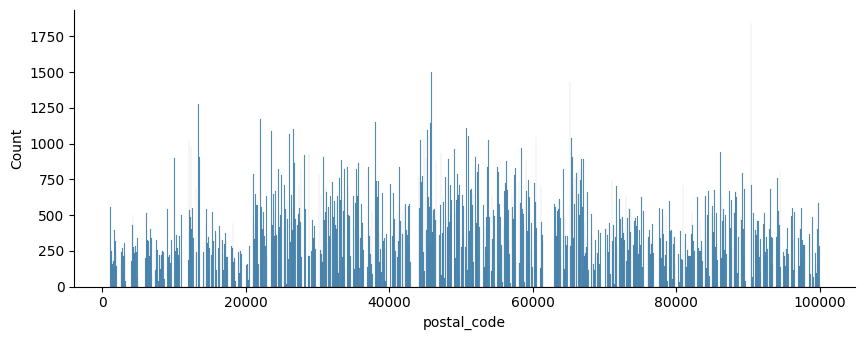

In [77]:
sns.displot(
    data.postal_code,
    bins=1000,
    height=3.5,
    aspect=2.5
);

In [78]:
data = data.drop(columns='postal_code')

#### Результаты обработки

In [79]:
dataset_initial_length = 354368

In [80]:
data.shape

(296240, 14)

In [81]:
round((1 - data.shape[0] / dataset_initial_length), 2)

0.16

 - в категориальных признакакх аномальных значений не обнаружено;
 - в количественных признаках удалены строки:
    - в целевой переменной `price` с _нулевыми_ значениями;
    - в признаке `registration_year` с аномальными значениями ниже `1910` и выше `2019`;
    - в признаке `power` с _нулевыми_ значениями и значениями ывше `400`
 - признак `number_of_pictures` содержить только нулевые значения и удалён полностью.
 - признак `postal_code` так же удалён
 - всего удалено 16% данных
 - размер датасета после обработки аномалий (296240, 15)

### Удаление неинформативных признаков

Признаки с датами:
 - `DateCrawled` — дата скачивания анкеты из базы
 - `DateCreated` — дата создания анкеты
 - `LastSeen` — дата последней активности пользователя
 
 Данные признаки не влияют на целевую переменную, то есть являются неинформативными. Удалим их.

In [82]:
date_columns

['date_crawled', 'date_created', 'last_seen']

In [83]:
data = data.drop(columns=date_columns)

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296240 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               296240 non-null  int64 
 1   vehicle_type        296240 non-null  object
 2   registration_year   296240 non-null  int64 
 3   gearbox             296240 non-null  object
 4   power               296240 non-null  int64 
 5   model               296240 non-null  object
 6   kilometer           296240 non-null  int64 
 7   registration_month  296240 non-null  int64 
 8   fuel_type           296240 non-null  object
 9   brand               296240 non-null  object
 10  repaired            296240 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.1+ MB


### Разбиение данных на выборки

In [85]:
target_name = 'price'

features = data.drop(columns=target_name)
target = data[target_name]

In [86]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [87]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=RANDOM_STATE)

In [88]:
features_train.shape, target_train.shape

((166635, 10), (166635,))

In [89]:
features_valid.shape, target_valid.shape

((55545, 10), (55545,))

In [90]:
features_test.shape, target_test.shape

((74060, 10), (74060,))

### Масштабирование признаков

In [91]:
features_train.head(3)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
75373,bus,2008,auto,170,touran,100000,3,petrol,volkswagen,no
132678,wagon,2008,manual,109,clubman,125000,4,gasoline,mini,no
157021,bus,2010,manual,140,other,150000,8,gasoline,mitsubishi,no


In [92]:
features_train.columns

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [93]:
numeric_features = list(features_train.select_dtypes([np.number]).columns)
numeric_features

['registration_year', 'power', 'kilometer', 'registration_month']

In [94]:
categorical_features = list(features_train.columns.difference(numeric_features))
categorical_features

['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']

In [95]:
features_train.describe().round(2)

,registration_year,power,kilometer,registration_month
count,166635.00,166635.00,166635.00,166635.00
mean,2002.83,120.13,128290.22,5.99
std,6.55,52.63,36830.92,3.59
min,1910.00,1.00,5000.00,0.00
25%,1999.00,75.00,125000.00,3.00
50%,2003.00,110.00,150000.00,6.00
75%,2007.00,150.00,150000.00,9.00
max,2016.00,400.00,150000.00,12.00


In [96]:
features_train_scaled = features_train.copy()
features_valid_scaled = features_valid.copy()
features_test_scaled = features_test.copy()

In [97]:
scaler = MinMaxScaler()
scaler.fit(features_train[numeric_features])
features_train_scaled[numeric_features] = scaler.transform(features_train[numeric_features])
features_valid_scaled[numeric_features] = scaler.transform(features_valid[numeric_features])
features_test_scaled[numeric_features] = scaler.transform(features_test[numeric_features])

In [98]:
features_train_scaled.describe().round(2)

,registration_year,power,kilometer,registration_month
count,166635.00,166635.00,166635.00,166635.00
mean,0.88,0.30,0.85,0.50
std,0.06,0.13,0.25,0.30
min,0.00,0.00,0.00,0.00
25%,0.84,0.19,0.83,0.25
50%,0.88,0.27,1.00,0.50
75%,0.92,0.37,1.00,0.75
max,1.00,1.00,1.00,1.00


In [99]:
features_test_scaled.describe().round(2)

,registration_year,power,kilometer,registration_month
count,74060.00,74060.00,74060.00,74060.00
mean,0.88,0.30,0.85,0.50
std,0.06,0.13,0.25,0.30
min,0.00,0.00,0.00,0.00
25%,0.84,0.19,0.83,0.25
50%,0.88,0.27,1.00,0.50
75%,0.92,0.37,1.00,0.75
max,1.00,1.00,1.00,1.00


In [100]:
features_train_scaled.shape

(166635, 10)

In [101]:
features_valid_scaled.shape

(55545, 10)

In [102]:
features_test_scaled.shape

(74060, 10)

### Кодирование признаков

#### Для линейных моделей

In [103]:
features_train_reg = features_train_scaled.copy()
features_valid_reg = features_valid_scaled.copy()
features_test_reg = features_test_scaled.copy()

In [104]:
features_train_reg.head(3)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
75373,bus,0.924528,auto,0.423559,touran,0.655172,0.250000,petrol,volkswagen,no
132678,wagon,0.924528,manual,0.270677,clubman,0.827586,0.333333,gasoline,mini,no
157021,bus,0.943396,manual,0.348371,other,1.000000,0.666667,gasoline,mitsubishi,no


In [105]:
categorical_features

['brand', 'fuel_type', 'gearbox', 'model', 'repaired', 'vehicle_type']

Сначала проверим соответствие значений признака `model` в выборках

In [106]:
models_train = set(features_train_reg.model.unique())
models_valid = set(features_valid_reg.model.unique())
models_test = set(features_test_reg.model.unique())
len(models_train), len(models_valid), len(models_test)

(249, 245, 249)

In [107]:
models_train - models_valid

{'amarok', 'i3', 'kalina', 'samara', 'serie_3'}

In [108]:
models_train - models_test

{'range_rover_evoque'}

In [109]:
models_valid - models_train

{'rangerover'}

In [110]:
models_test - models_train

{'rangerover'}

In [111]:
models_test - models_valid

{'amarok', 'i3', 'kalina', 'samara', 'serie_3'}

In [112]:
models_valid - models_test

{'range_rover_evoque'}

В `train` выборке нет значчения `rangerover` по сравнению с `valid` и `test` выборками

In [113]:
one_hot_encoder_reg = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [114]:
one_hot_encoder_reg.fit(features_train_reg[categorical_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [115]:
def one_hot_encoder_transform(one_hot_encoder, df, cat_features):
    df[one_hot_encoder.get_feature_names_out()] = one_hot_encoder.transform(df[cat_features])
    return df.drop(cat_features, axis=1)

In [116]:
features_train_reg = one_hot_encoder_transform(
    one_hot_encoder_reg,
    features_train_reg,
    categorical_features
)

In [117]:
features_valid_reg = one_hot_encoder_transform(
    one_hot_encoder_reg,
    features_valid_reg,
    categorical_features
)

In [118]:
features_test_reg = one_hot_encoder_transform(
    one_hot_encoder_reg,
    features_test_reg,
    categorical_features
)

In [119]:
features_train_reg.shape, features_valid_reg.shape, features_test_reg.shape

((166635, 310), (55545, 310), (74060, 310))

#### Для моделей на основе дерева решений

In [120]:
features_train_tree = features_train_scaled.copy()
features_valid_tree = features_valid_scaled.copy()
features_test_tree = features_test_scaled.copy()

In [121]:
features_train_tree.shape, features_valid_tree.shape, features_test_tree.shape

((166635, 10), (55545, 10), (74060, 10))

Категориальные признаки, кроме `model`, кодируем с помощью `OneHotEncoder`\
Признак `model` с помощью `OrdinalEncoder`

In [122]:
categorical_features_tree = categorical_features.copy()
categorical_features_tree.remove('model')
categorical_features_tree

['brand', 'fuel_type', 'gearbox', 'repaired', 'vehicle_type']

In [123]:
one_hot_encoder_tree = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [124]:
one_hot_encoder_tree.fit(features_train_tree[categorical_features_tree])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [125]:
features_train_tree = one_hot_encoder_transform(
    one_hot_encoder_tree,
    features_train_tree,
    categorical_features_tree
)

In [126]:
features_valid_tree = one_hot_encoder_transform(
    one_hot_encoder_tree,
    features_valid_tree,
    categorical_features_tree
)

In [127]:
features_test_tree = one_hot_encoder_transform(
    one_hot_encoder_tree,
    features_test_tree,
    categorical_features_tree
)

In [128]:
features_train_tree.shape, features_valid_tree.shape, features_test_tree.shape

((166635, 63), (55545, 63), (74060, 63))

In [129]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [130]:
ordinal_encoder.fit(features_train_tree[['model']])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [131]:
features_train_tree.model = ordinal_encoder.transform(features_train_tree[['model']])
features_valid_tree.model = ordinal_encoder.transform(features_valid_tree[['model']])
features_test_tree.model = ordinal_encoder.transform(features_test_tree[['model']])

In [132]:
features_train_tree.head(3)

,registration_year,power,model,kilometer,registration_month,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,gearbox_manual,gearbox_unknown,repaired_unknown,repaired_yes,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon
75373,0.924528,0.423559,220.0,0.655172,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132678,0.924528,0.270677,77.0,0.827586,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
157021,0.943396,0.348371,166.0,1.000000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
features_valid_tree.head(3)

,registration_year,power,model,kilometer,registration_month,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,gearbox_manual,gearbox_unknown,repaired_unknown,repaired_yes,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon
162491,0.905660,0.373434,28.0,0.827586,0.250000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
278869,0.924528,0.624060,223.0,0.586207,0.750000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92131,0.896226,0.147870,128.0,0.827586,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [134]:
features_test_tree.head(3)

,registration_year,power,model,kilometer,registration_month,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,gearbox_manual,gearbox_unknown,repaired_unknown,repaired_yes,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon
134737,0.896226,0.498747,116.0,1.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
144018,0.952830,0.423559,28.0,0.517241,0.250000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
61657,0.764151,0.185464,42.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Обучение моделей

Подготовим датафрейм для репорта по обучению

In [135]:
TRAIN_SHAPE = 'Размер обучающей выборки'
FIT_TIME = 'Время обучения, сек.'
PREDICT_TIME = 'Время 1-го предсказания, мс.'
RMSE = 'RMSE'

report_columns = [TRAIN_SHAPE, FIT_TIME, PREDICT_TIME, RMSE]

train_report = pd.DataFrame(columns=report_columns)
train_report['model'] = []
train_report.set_index('model', inplace=True)
train_report

,Размер обучающей выборки,"Время обучения, сек.","Время 1-го предсказания, мс.",RMSE
model,,,,


In [136]:
def update_train_report(model_name, train_shape, fit_time, predict_time, rmse):
    fit_time = round(fit_time.average, 2)
    predict_time = round((predict_time.average * 1000), 2)
    
    train_report.loc[model_name, TRAIN_SHAPE] = train_shape
    train_report.loc[model_name, FIT_TIME] = fit_time
    train_report.loc[model_name, PREDICT_TIME] = predict_time
    train_report.loc[model_name, RMSE] = rmse
    
    print('Результаты обучения модели', model_name)
    display(train_report.loc[model_name])

### Модель `LinearRegression`

In [137]:
lin_reg_model = LinearRegression()

lin_reg_fit_time = %timeit -n 1 -r 1 -o lin_reg_model.fit(features_train_reg, target_train)

6.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [138]:
lin_reg_predict_time = %timeit -o lin_reg_model.predict(features_train_reg.iloc[:1])

4.09 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [139]:
predicted_valid = lin_reg_model.predict(features_valid_reg)
lin_reg_rmse = mean_squared_error(target_valid, predicted_valid, squared=False).round(2)

In [140]:
update_train_report(
    type(lin_reg_model).__name__,
    features_train_reg.shape,
    lin_reg_fit_time,
    lin_reg_predict_time,
    lin_reg_rmse
)

Результаты обучения модели LinearRegression


Размер обучающей выборки        (166635, 310)
Время обучения, сек.                     6.01
Время 1-го предсказания, мс.             4.09
RMSE                                   2583.3
Name: LinearRegression, dtype: object

### Модель `Ridge`

Для настройки гиперпараметров будем использовать библиотеку `optuna`. Подготовим необходимые функции.

In [141]:
def tune(objective, n_trials=10):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    best_params = study.best_params
    best_score = study.best_value
    print('Best score:', round(abs(best_score), 2))
    print('Best parameters:', best_params)
    print()
    return best_score, best_params

In [142]:
def ridge_objective(trial):
    params = {}
    params['alpha'] = trial.suggest_float('alpha', 0.01, 3)
    params['random_state'] = RANDOM_STATE

    ridge = Ridge(**params)

    return cross_val_score(
        ridge,
        features_train_reg,
        target_train,
        scoring='neg_root_mean_squared_error'
    ).mean()

In [143]:
%%time
ridge_best_score, ridge_params = tune(ridge_objective)

Best score: 2582.82
Best parameters: {'alpha': 1.7976543864222738}

CPU times: total: 2min 10s
Wall time: 30 s


In [144]:
ridge = Ridge(**ridge_params, random_state=RANDOM_STATE)

ridge_fit_time = %timeit -n 3 -r 1 -o ridge.fit(features_train_reg, target_train)

757 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [145]:
ridge_predict_time = %timeit -o ridge.predict(features_train_reg.iloc[:1])

4.23 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [146]:
predicted_valid = ridge.predict(features_valid_reg)
ridge_rmse = mean_squared_error(target_valid, predicted_valid, squared=False).round(2)

In [147]:
update_train_report(
    Ridge.__name__,
    features_train_reg.shape,
    ridge_fit_time,
    ridge_predict_time,
    ridge_rmse
)

Результаты обучения модели Ridge


Размер обучающей выборки        (166635, 310)
Время обучения, сек.                     0.76
Время 1-го предсказания, мс.             4.23
RMSE                                  2583.63
Name: Ridge, dtype: object

### Модель `Lasso`

In [148]:
def lasso_objective(trial):
    params = {}
    params['alpha'] = trial.suggest_float('alpha', 0.0001, 1)
    params['random_state'] = RANDOM_STATE

    lasso = Lasso(**params)

    return cross_val_score(
        lasso,
        features_train_reg,
        target_train,
        scoring='neg_root_mean_squared_error'
    ).mean()

In [149]:
# %%time
# lasso_best_score, lasso_params = tune(lasso_objective, n_trials=5)
# uncomment for tuning

In [150]:
# comment this cell when tuning
lasso_params = {'alpha': 0.12020972115735393}
# the parameter values were obtained during the tuning

In [151]:
lasso = Lasso(**lasso_params, random_state=RANDOM_STATE)

lasso_fit_time = %timeit -n 1 -r 1 -o lasso.fit(features_train_reg, target_train)

1min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [152]:
lasso_predict_time = %timeit -o lasso.predict(features_train_reg.iloc[:1])

5.28 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [153]:
predicted_train = lasso.predict(features_train_reg)
lasso_rmse = mean_squared_error(target_train, predicted_train, squared=False).round(2)

In [154]:
predicted_train = lasso.predict(features_valid_reg)
lasso_rmse = mean_squared_error(target_valid, predicted_train, squared=False).round(2)

In [155]:
update_train_report(
    Lasso.__name__,
    features_train_reg.shape,
    lasso_fit_time,
    lasso_predict_time,
    lasso_rmse
)

Результаты обучения модели Lasso


Размер обучающей выборки        (166635, 310)
Время обучения, сек.                    62.62
Время 1-го предсказания, мс.             5.28
RMSE                                  2585.09
Name: Lasso, dtype: object

### Модель `DecisionTreeRegressor`

In [156]:
def decision_tree_reg_objective(trial):
    params = {}
    params['max_depth'] = trial.suggest_int('max_depth', 20, 30)
    params['min_samples_split'] = trial.suggest_int('min_samples_split', 30, 50)
    params['min_samples_leaf'] = trial.suggest_int('min_samples_leaf', 5, 15)

#     params['max_depth'] = 27
#     params['min_samples_split'] = 42
#     params['min_samples_leaf'] = 6
    params['random_state'] = RANDOM_STATE

    model = DecisionTreeRegressor(**params)

    return cross_val_score(
        model,
        features_train_tree,
        target_train,
        scoring='neg_root_mean_squared_error'
    ).mean()

In [157]:
# %%time
# decision_tree_reg_best_score, decision_tree_reg_params = tune(decision_tree_reg_objective, n_trials=50)
# uncomment for tuning

In [158]:
# comment this cell when tuning
decision_tree_reg_params = {
    'max_depth': 27,
    'min_samples_split': 42,
    'min_samples_leaf': 6
}
# the parameter values were obtained during the tuning

In [159]:
decision_tree_reg = DecisionTreeRegressor(
    **decision_tree_reg_params,
    random_state=RANDOM_STATE
)
dt_reg_fit_time = %timeit -n 3 -r 1 -o decision_tree_reg.fit(features_train_tree, target_train)

2.62 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [160]:
dt_reg_predict_time = %timeit -o decision_tree_reg.predict(features_train_tree.iloc[:1])

2.72 ms ± 346 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [161]:
predicted_valid = decision_tree_reg.predict(features_valid_tree)
dt_reg_rmse = mean_squared_error(target_valid, predicted_valid, squared=False).round(2)

In [162]:
update_train_report(
    DecisionTreeRegressor.__name__,
    features_train_reg.shape,
    dt_reg_fit_time,
    dt_reg_predict_time,
    dt_reg_rmse
)

Результаты обучения модели DecisionTreeRegressor


Размер обучающей выборки        (166635, 310)
Время обучения, сек.                     2.62
Время 1-го предсказания, мс.             2.72
RMSE                                   1784.3
Name: DecisionTreeRegressor, dtype: object

### Модель `RandomForestRegressor`

In [163]:
def random_forest_reg_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int('n_estimators', 5, 150)
    params['max_depth'] = trial.suggest_int('max_depth', 7, 15)

#     params['n_estimators'] = 86
#     params['max_depth'] = 14
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1

    model = RandomForestRegressor(**params)

    return cross_val_score(
        model,
        features_train_tree,
        target_train,
        cv=3,
        scoring='neg_root_mean_squared_error'
    ).mean()

In [164]:
# %%time
# best_score, random_forest_reg_params = tune(random_forest_reg_objective, n_trials=8)
# uncomment for tuning

In [165]:
# comment this cell when tuning
random_forest_reg_params = {
    'n_estimators': 86,
    'max_depth': 14
}
# the parameter values were obtained during the tuning

In [166]:
random_forest_reg = RandomForestRegressor(
    **random_forest_reg_params,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
random_forest_reg_fit_time = %timeit -n 1 -r 1 -o random_forest_reg.fit(features_train_tree, target_train)

31.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [167]:
random_forest_reg_predict_time = %timeit -o random_forest_reg.predict(features_train_tree.iloc[:1])

30.4 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [168]:
predicted_valid = random_forest_reg.predict(features_valid_tree)
random_forest_reg_rmse = mean_squared_error(target_valid, predicted_valid, squared=False).round(2)

In [169]:
update_train_report(
    RandomForestRegressor.__name__,
    features_train_reg.shape,
    random_forest_reg_fit_time,
    random_forest_reg_predict_time,
    random_forest_reg_rmse
)

Результаты обучения модели RandomForestRegressor


Размер обучающей выборки        (166635, 310)
Время обучения, сек.                    31.07
Время 1-го предсказания, мс.            30.36
RMSE                                  1683.57
Name: RandomForestRegressor, dtype: object

### Модель `CatBoostRegressor`

In [170]:
EARLY_STOPPING_ROUNDS = 50

In [171]:
def catboost_reg_objective(trial):
    params = {}
    params['iterations'] = trial.suggest_int('iterations', 10, 500)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.1, 0.8)
    params['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.0)

    params['boosting_type'] = 'Plain'
    params['use_best_model'] = True
    params['eval_metric'] = 'RMSE'
    params['random_state'] = RANDOM_STATE
    params['cat_features'] = categorical_features
    params['logging_level'] = 'Silent'
    
    model = CatBoostRegressor(**params)
    model.fit(
        features_train, target_train,
        eval_set=(features_valid, target_valid),
        early_stopping_rounds=EARLY_STOPPING_ROUNDS
    )
    
    return mean_squared_error(target_valid, model.predict(features_valid), squared=False)

In [172]:
# %%time
# catboost_study = optuna.create_study()
# catboost_study.optimize(catboost_reg_objective, n_trials=10, n_jobs=-1)
# uncomment for tuning

In [173]:
# uncomment for tuning
# catboost_reg_rmse = round(abs(catboost_study.best_value), 2)
# catboost_reg_params = catboost_study.best_params
# print('Best score:', catboost_reg_rmse)
# print('Best parameters:', catboost_reg_params)

In [174]:
# comment this cell when tuning
catboost_reg_params = {
    'iterations': 453,
    'learning_rate': 0.4529175618133735,
    'l2_leaf_reg': 2.492518280470015
}
# the parameter values were obtained during the tuning

In [175]:
catboost_regressor = CatBoostRegressor(
    **catboost_reg_params,
    cat_features=categorical_features,
    use_best_model=True,
    eval_metric='RMSE',
    random_state=RANDOM_STATE,
    logging_level='Silent'
)

In [176]:
catboost_reg_fit_time = %timeit -n 1 -r 1 -o catboost_regressor.fit( \
    features_train, \
    target_train, \
    eval_set=(features_valid, target_valid), \
    early_stopping_rounds=EARLY_STOPPING_ROUNDS \
)

1min 15s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [177]:
catboost_reg_predict_time = %timeit -o catboost_regressor.predict(features_train.iloc[:1])

2.34 ms ± 58.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [178]:
predicted_valid = catboost_regressor.predict(features_valid)
catboost_reg_rmse = mean_squared_error(target_valid, predicted_valid, squared=False).round(2)

In [179]:
update_train_report(
    CatBoostRegressor.__name__,
    features_train.shape,
    catboost_reg_fit_time,
    catboost_reg_predict_time,
    catboost_reg_rmse
)

Результаты обучения модели CatBoostRegressor


Размер обучающей выборки        (166635, 10)
Время обучения, сек.                   75.62
Время 1-го предсказания, мс.            2.34
RMSE                                 1591.57
Name: CatBoostRegressor, dtype: object

### Модель `LGBMRegressor`

In [180]:
features_train_lgbm = features_train
features_valid_lgbm = features_valid
features_test_lgbm = features_test

In [181]:
for feature_name in categorical_features:
    features_train_lgbm[feature_name] = features_train_lgbm[feature_name].astype('category')
    features_valid_lgbm[feature_name] = features_valid_lgbm[feature_name].astype('category')
    features_test_lgbm[feature_name] = features_test_lgbm[feature_name].astype('category')

In [182]:
def lightgbm_reg_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int("n_estimators", 10, 100)
    params['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 1)
    params['max_depth'] = trial.suggest_int("max_depth", 1, 10)
    params['num_leaves'] = trial.suggest_int("num_leaves", 50, 100)
    params['reg_alpha'] = trial.suggest_float('reg_alpha', 0.01, 10)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 0.01, 10)
    
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    params['verbose'] = -1
    
    model = LGBMRegressor(**params)
    model.fit(
        features_train_lgbm,
        target_train,
        eval_set=[(features_valid_lgbm, target_valid)],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        verbose=False
    )
    
    return mean_squared_error(target_valid, model.predict(features_valid_lgbm), squared=False)

In [183]:
%%time
study = optuna.create_study()
study.optimize(lightgbm_reg_objective, n_trials=100, n_jobs=-1)

CPU times: total: 10min 41s
Wall time: 1min 40s


In [184]:
lightgbm_reg_rmse = round(abs(study.best_value), 2)
lightgbm_reg_params = study.best_params
print('Best score:', lightgbm_reg_rmse)
print('Best parameters:', lightgbm_reg_params)

Best score: 1563.33
Best parameters: {'n_estimators': 97, 'learning_rate': 0.22982502910462022, 'max_depth': 8, 'num_leaves': 72, 'reg_alpha': 9.998246050668081, 'reg_lambda': 8.111420354337007}


In [185]:
lightgbm_regressor = LGBMRegressor(
    **lightgbm_reg_params,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

In [186]:
lightgbm_reg_fit_time = %timeit -n 1 -r 1 -o lightgbm_regressor.fit( \
    features_train_lgbm, \
    target_train, \
    eval_set=[(features_valid_lgbm, target_valid)], \
    eval_metric='rmse', \
    categorical_feature=categorical_features, \
    verbose=False \
)

1.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [187]:
lightgbm_reg_predict_time = %timeit -o lightgbm_regressor.predict(features_train_lgbm.iloc[:1])

10.3 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [188]:
predicted_valid = lightgbm_regressor.predict(features_valid_lgbm)
lightgbm_reg_rmse = mean_squared_error(target_valid, predicted_valid, squared=False).round(2)
lightgbm_reg_rmse

1563.33

In [189]:
update_train_report(
    LGBMRegressor.__name__,
    features_train_lgbm.shape,
    lightgbm_reg_fit_time,
    lightgbm_reg_predict_time,
    lightgbm_reg_rmse
)

Результаты обучения модели LGBMRegressor


Размер обучающей выборки        (166635, 10)
Время обучения, сек.                    1.63
Время 1-го предсказания, мс.           10.29
RMSE                                 1563.33
Name: LGBMRegressor, dtype: object

### Модель `DummyRegressor`

In [190]:
dummy_regressor = DummyRegressor()

dummy_reg_fit_time = %timeit -n 1 -r 1 -o dummy_regressor.fit(features_train_reg, target_train)

1.23 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [191]:
dummy_reg_predict_time = %timeit -o dummy_regressor.predict(features_train_reg.iloc[:1])

88 µs ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [192]:
predicted_valid = dummy_regressor.predict(features_valid_reg)
dummy_reg_rmse = mean_squared_error(target_valid, predicted_valid, squared=False).round(2)

In [193]:
update_train_report(
    type(dummy_regressor).__name__,
    features_train_reg.shape,
    dummy_reg_fit_time,
    dummy_reg_predict_time,
    dummy_reg_rmse
)

Результаты обучения модели DummyRegressor


Размер обучающей выборки        (166635, 310)
Время обучения, сек.                      0.0
Время 1-го предсказания, мс.             0.09
RMSE                                  4602.47
Name: DummyRegressor, dtype: object

## Анализ моделей

Посмотрим результаты обучения разных моделей вместе

In [194]:
train_report

,Размер обучающей выборки,"Время обучения, сек.","Время 1-го предсказания, мс.",RMSE
model,,,,
LinearRegression,"(166635, 310)",6.01,4.09,2583.3
Ridge,"(166635, 310)",0.76,4.23,2583.63
Lasso,"(166635, 310)",62.62,5.28,2585.09
DecisionTreeRegressor,"(166635, 310)",2.62,2.72,1784.3
RandomForestRegressor,"(166635, 310)",31.07,30.36,1683.57
CatBoostRegressor,"(166635, 10)",75.62,2.34,1591.57
LGBMRegressor,"(166635, 10)",1.63,10.29,1563.33
DummyRegressor,"(166635, 310)",0.0,0.09,4602.47


In [195]:
RMSE_TEST = 'RMSE на тесте'
R2_SCORE = 'R2 на тесте'

final_report = train_report
final_report = final_report.rename(columns={RMSE: 'RMSE на обучении'})

In [196]:
def update_final_report(model_name, rmse, r2):
    final_report.loc[model_name, RMSE_TEST] = rmse.round(2)
    final_report.loc[model_name, R2_SCORE] = r2.round(2)

In [197]:
def test_model(model, features_test):
    predicted_test = model.predict(features_test)
    update_final_report(
        type(model).__name__,
        mean_squared_error(target_test, predicted_test, squared=False),
        r2_score(target_test, predicted_test)
    )

In [198]:
test_model(lin_reg_model, features_test_reg)

In [199]:
test_model(ridge, features_test_reg)

In [200]:
test_model(lasso, features_test_reg)

In [201]:
test_model(decision_tree_reg, features_test_tree)

In [202]:
test_model(random_forest_reg, features_test_tree)

In [203]:
test_model(catboost_regressor, features_test)

In [204]:
test_model(lightgbm_regressor, features_test)

## Общий вывод

In [205]:
final_report

,Размер обучающей выборки,"Время обучения, сек.","Время 1-го предсказания, мс.",RMSE на обучении,RMSE на тесте,R2 на тесте
model,,,,,,
LinearRegression,"(166635, 310)",6.01,4.09,2583.3,2593.82,0.68
Ridge,"(166635, 310)",0.76,4.23,2583.63,2593.79,0.68
Lasso,"(166635, 310)",62.62,5.28,2585.09,2595.36,0.68
DecisionTreeRegressor,"(166635, 310)",2.62,2.72,1784.3,1769.00,0.85
RandomForestRegressor,"(166635, 310)",31.07,30.36,1683.57,1684.05,0.87
CatBoostRegressor,"(166635, 10)",75.62,2.34,1591.57,1579.80,0.88
LGBMRegressor,"(166635, 10)",1.63,10.29,1563.33,1565.76,0.88
DummyRegressor,"(166635, 310)",0.0,0.09,4602.47,NaN,NaN


Результаты по времени обучения:
 - лучшее время на обучении показала модель `Ridge`;
 - худшее время на обучении показала модель `Lasso`, `CatBoostRegressor`;


Результаты по времени предсказания на одном объекте:
 - лучшее время у модели `CatBoostRegressor`;
 - худшее время у модели `RandomForestRegressor`;
 - ряд простых моделей `LinearRegression`, `Ridge`, `Lasso`, а также модель `DecisionTreeRegressor` показывают время не более `6` милисекунд


Результаты по качеству:
 - и на обучении и на тесте лучшее качество у модели `LGBMRegressor`;
 - простые линейные модели `LinearRegression`, `Ridge`, `Lasso` не смогли преодолеть порог `2500`;